<a href="https://colab.research.google.com/github/EleazarBE/Yamnet2.0-/blob/main/yamnet2.0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2020 The TensorFlow Hub Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [ ]:
#@title Copyright 2020 The TensorFlow Hub Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/hub/tutorials/yamnet"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/hub/tutorials/yamnet.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/hub/tutorials/yamnet.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/hub/tutorials/yamnet.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
  <td>
    <a href="https://tfhub.dev/google/yamnet/1"><img src="https://www.tensorflow.org/images/hub_logo_32px.png" />See TF Hub model</a>
  </td>
</table>

In [ ]:
!apt install ffmpeg -y
!pip install pydub


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


# Sound classification with YAMNet

YAMNet is a deep net that predicts 521 audio event [classes](https://github.com/tensorflow/models/blob/master/research/audioset/yamnet/yamnet_class_map.csv) from the [AudioSet-YouTube corpus](http://g.co/audioset) it was trained on. It employs the
[Mobilenet_v1](https://arxiv.org/pdf/1704.04861.pdf) depthwise-separable
convolution architecture.

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import csv

import matplotlib.pyplot as plt
from IPython.display import Audio
from scipy.io import wavfile

import soundfile as sf
import librosa
from google.colab import output
from IPython.display import Javascript
from base64 import b64decode


Load the Model from TensorFlow Hub.

Note: to read the documentation just follow the model's [url](https://tfhub.dev/google/yamnet/1)

In [ ]:
# Load the model.
model = hub.load('https://tfhub.dev/google/yamnet/1')

The labels file will be loaded from the models assets and is present at `model.class_map_path()`.
You will load it on the `class_names` variable.

In [ ]:
# Find the name of the class with the top score when mean-aggregated across frames.
def class_names_from_csv(class_map_csv_text):
  """Returns list of class names corresponding to score vector."""
  class_names = []
  with tf.io.gfile.GFile(class_map_csv_text) as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
      class_names.append(row['display_name'])

  return class_names

class_map_path = model.class_map_path().numpy()
class_names = class_names_from_csv(class_map_path)

Add a method to verify and convert a loaded audio is on the proper sample_rate (16K), otherwise it would affect the model's results.

In [ ]:
def ensure_sample_rate(original_sample_rate, waveform,
                       desired_sample_rate=16000):
  """Resample waveform if required."""
  if original_sample_rate != desired_sample_rate:
    desired_length = int(round(float(len(waveform)) /
                               original_sample_rate * desired_sample_rate))
    waveform = scipy.signal.resample(waveform, desired_length)
  return desired_sample_rate, waveform

Input your audio by enabling your microphone

In [ ]:
# --- Setup ---
from IPython.display import Javascript, Audio, display
from base64 import b64decode
from google.colab import output
from pydub import AudioSegment
import soundfile as sf
import librosa
import numpy as np

# --- JavaScript Mic Recorder ---
RECORD = """
const sleep = time => new Promise(resolve => setTimeout(resolve, time))
const b2text = blob => new Promise(resolve => {
  const reader = new FileReader();
  reader.onloadend = () => resolve(reader.result);
  reader.readAsDataURL(blob);
});

async function record(sec=3){
  const stream = await navigator.mediaDevices.getUserMedia({audio:true});
  const mediaRecorder = new MediaRecorder(stream);
  const audioChunks = [];

  mediaRecorder.ondataavailable = e => audioChunks.push(e.data);
  mediaRecorder.start();

  await sleep(sec * 1000);
  mediaRecorder.stop();

  const audioBlob = await new Promise(resolve => {
    mediaRecorder.onstop = () => resolve(new Blob(audioChunks));
  });

  stream.getTracks().forEach(track => track.stop());

  const base64data = await b2text(audioBlob);
  google.colab.kernel.invokeFunction('notebook.save_audio', [base64data], {});
}
"""

# --- Save Audio Callback ---
def save_audio(data):
    audio_bytes = b64decode(data.split(',')[1])
    with open('mic_recording.webm', 'wb') as f:
        f.write(audio_bytes)
    print("✅ Audio saved as 'mic_recording.webm'")

output.register_callback('notebook.save_audio', save_audio)

# --- Record ---
print("🎙️ Recording from mic for 10 seconds...")
display(Javascript(RECORD))
output.eval_js("record(10)")

🎙️ Recording from mic for 10 seconds...


<IPython.core.display.Javascript object>

✅ Audio saved as 'mic_recording.webm'


In [ ]:
# --- Convert WebM to true WAV ---
try:
    audio = AudioSegment.from_file("mic_recording.webm", format="webm")
except:
    audio = AudioSegment.from_file("mic_recording.webm", format="ogg")

audio.export("converted.wav", format="wav")
print("✅ Converted to WAV")

# --- Read & Analyze WAV ---
wav_data, sample_rate = sf.read("converted.wav")

# ✅ Ensure mono
if len(wav_data.shape) == 2:
    print("🎧 Stereo input detected — converting to mono")
    wav_data = np.mean(wav_data, axis=1)

# ✅ Normalize to [-1.0, 1.0]
wav_data = wav_data.astype(np.float32)
waveform = wav_data / np.max(np.abs(wav_data))

# ✅ Resample to 16kHz if needed
def ensure_sample_rate(original_sr, waveform, target_sr=16000):
    if original_sr != target_sr:
        print(f"🔁 Resampling from {original_sr} Hz to {target_sr} Hz")
        waveform = librosa.resample(waveform, orig_sr=original_sr, target_sr=target_sr)
        return target_sr, waveform
    return original_sr, waveform

sample_rate, waveform = ensure_sample_rate(sample_rate, waveform)

# --- Debug Print ---
print("🔍 Final waveform shape:", waveform.shape)
print("🔍 Sample rate:", sample_rate)
print("🔍 Max amplitude:", np.max(np.abs(waveform)))
print("🔍 Min amplitude:", np.min(waveform))
print(f"📏 Duration: {len(waveform) / sample_rate:.2f} seconds")

# --- Optional: Listen to the result ---
Audio("converted.wav")

✅ Converted to WAV
🔁 Resampling from 48000 Hz to 16000 Hz
🔍 Final waveform shape: (158400,)
🔍 Sample rate: 16000
🔍 Max amplitude: 1.0204766
🔍 Min amplitude: -1.0204766
📏 Duration: 9.90 seconds


The `wav_data` needs to be normalized to values in `[-1.0, 1.0]` (as stated in the model's [documentation](https://tfhub.dev/google/yamnet/1)).

In [ ]:
waveform = wav_data / np.max(np.abs(wav_data))

## Executing the Model

Now the easy part: using the data already prepared, you just call the model and get the: scores, embedding and the spectrogram.

The score is the main result you will use.
The spectrogram you will use to do some visualizations later.

In [ ]:
# Run the model, check the output.
scores, embeddings, spectrogram = model(waveform)

In [ ]:
scores_np = scores.numpy()
spectrogram_np = spectrogram.numpy()
infered_class = class_names[scores_np.mean(axis=0).argmax()]
print(f'The main sound is: {infered_class}')

The main sound is: Music


## Visualization

YAMNet also returns some additional information that we can use for visualization.
Let's take a look on the Waveform, spectrogram and the top classes inferred.

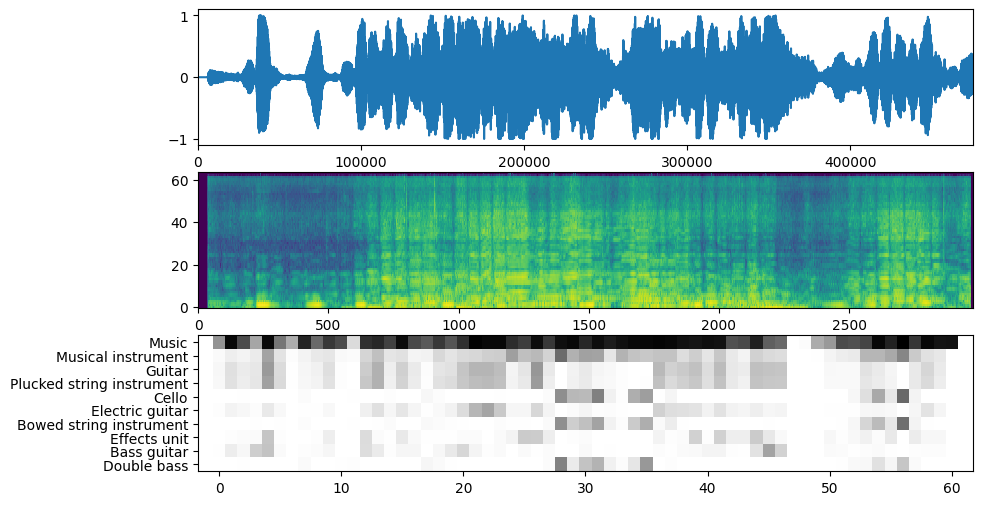

In [ ]:
plt.figure(figsize=(10, 6))

# Plot the waveform.
plt.subplot(3, 1, 1)
plt.plot(waveform)
plt.xlim([0, len(waveform)])

# Plot the log-mel spectrogram (returned by the model).
plt.subplot(3, 1, 2)
plt.imshow(spectrogram_np.T, aspect='auto', interpolation='nearest', origin='lower')

# Plot and label the model output scores for the top-scoring classes.
mean_scores = np.mean(scores, axis=0)
top_n = 10
top_class_indices = np.argsort(mean_scores)[::-1][:top_n]
plt.subplot(3, 1, 3)
plt.imshow(scores_np[:, top_class_indices].T, aspect='auto', interpolation='nearest', cmap='gray_r')

# patch_padding = (PATCH_WINDOW_SECONDS / 2) / PATCH_HOP_SECONDS
# values from the model documentation
patch_padding = (0.025 / 2) / 0.01
plt.xlim([-patch_padding-0.5, scores.shape[0] + patch_padding-0.5])
# Label the top_N classes.
yticks = range(0, top_n, 1)
plt.yticks(yticks, [class_names[top_class_indices[x]] for x in yticks])
_ = plt.ylim(-0.5 + np.array([top_n, 0]))